In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import util as ut
from shallowNet.shallowNet import shallowNet, DenseTranspose
import matplotlib.pyplot as plt 
import copy
import matplotlib.cm as cm
from shallowNet.shallowNet import shallowNet

In [2]:
epochs = 20 
batch_size = 5
# generate the trainig set 
print("[INFO] generating trainnig dataset...")
(trainX, trainY) = ut.generate_training_sat(32, 100)

# generate the test set 
print("[INFO] generating testing dataset...")
(testX, testY) = ut.generate_training_sat(32,50)

[INFO] generating trainnig dataset...
[INFO] generating testing dataset...


In [4]:
model1 = shallowNet.build()
H1= model1.fit(
    trainY, trainY,
    #validation_data = (testY, testY),
    epochs = epochs,
    batch_size = batch_size,
)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                825       
_________________________________________________________________
dense_transpose (DenseTransp (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 0s 2ms/step - loss: 0.3100
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2632
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2339
Epoch 4/20
20/20 [======

In [5]:
def plot_model_loss(model_fit, path):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), model_fit.history["loss"], label="train_loss")
    #plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Accuracy\n")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(path)
    plt.show()

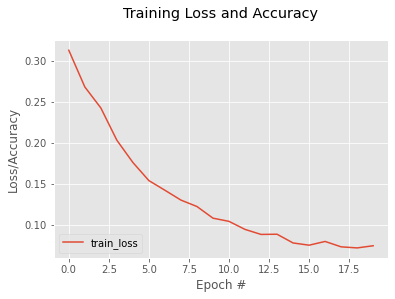

In [160]:
plot_model_loss(H, "loss_plot_model_1.png")

In [169]:
def plot_weights_model(model, path="weight_plot_default_name.png", number_of_deep_layers_to_show = None):
    """
    Visualize weights of model. 
    If added hidden layers is more than 1, then the function shows
    number of hidden layers, starting from the deepest one,
    defined by the param: number_of_deep_layers_to_show

    Params:
        model - model to show 
        path (default: weight_plot_default_name.png)- path where the plot with weights shall be ploted 
    Optional params: 
        number_of_deepl_layers_to_show (defult: all layers)- number of deep layers to print

    Possible Erros:
        number_of_deepl_layers_to_show cannot be greater than the actual 
        number of added layers
    """
    number_of_convoluted_layers = 0
    transpose_layer_type = type(DenseTranspose(None))
    layers_to_show = []
    for l in model.layers:
        if type(l) == transpose_layer_type: # compare types of convoluted layers
            number_of_convoluted_layers += 1
            layers_to_show.append(l)

    if number_of_deep_layers_to_show == None: # if param is None then show all convoluted layers 
        number_of_deep_layers_to_show = number_of_convoluted_layers
        
    # check if number of layers to show is fine
    assert number_of_convoluted_layers + 1 > number_of_deep_layers_to_show, "number of layers to visualize cannot exceded the real number of convoluted layers"  

    print("[INFO]: number of convoluted layers is equal to: ", number_of_convoluted_layers)
    index = 0



    if number_of_deep_layers_to_show == 1: # show encoder and decoder weights 
        fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout = True)
        fig.suptitle('Encoder/Decoder Weights', fontsize=16)
        im =axes[0].imshow(layers_to_show[0].weights_transpose.numpy().transpose(), interpolation='nearest', cmap=cm.Greys_r)
        axes[0].set_title("Encoder")
        axes[0].set_ylabel("Visible")
        axes[0].set_xlabel("Hidden")
        im =axes[1].imshow(layers_to_show[0].weights_transpose.numpy().transpose(), interpolation='nearest', cmap=cm.Greys_r)
        axes[1].set_title("Decoder")
        axes[1].set_ylabel("Visible")
        axes[1].set_xlabel("Hidden")
    else: # show hidden deep layers weights 
        fig, axes = plt.subplots(nrows=1, ncols=number_of_deep_layers_to_show, constrained_layout = True)
        fig.suptitle('Weights Matrix Image Reconstruction', fontsize=16)
        for ax in axes.flat:
            im = ax.imshow(layers_to_show[index].weights_transpose.numpy().transpose(), interpolation='nearest', cmap=cm.Greys_r)
            ax.set_title("Conv Layer : " + str(index))
            ax.set_xlabel("Hidden")
            ax.set_ylabel("Vissible")
            index+=1
    fig.colorbar(im, ax=axes.ravel().tolist())
    #plt.savefig(path)
    plt.show()  

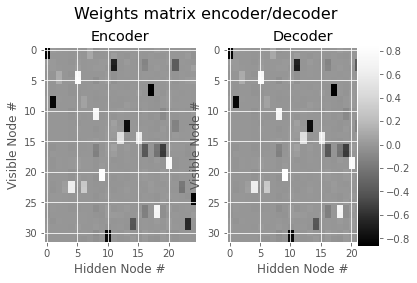

In [171]:
plot_weights_mode(model1, "weights_plot_model_1.png")

In [7]:
def split_model_into_encoder_decoder(model, show_summary = False):
    layer_to_split = model.layers[0]
    index_to_split = 0
    # the code here might be simpler stoping at the denseTranspose type, but its more robust
    for i in range(len(model.layers)):
        if model.layers[i].output.shape[-1] <= layer_to_split.output.shape[-1]:
            layer_to_split = model.layers[i]
            index_to_split = i 
    index_to_split +=1

    inputs_encoder = model.inputs
    x = inputs_encoder
    for new_layer_encoder in model.layers[1:index_to_split]:
        x = new_layer_encoder(x)
    encoder_ = tf.keras.Model(inputs_encoder, x)

    latent_shape = encoder_.layers[-1].output.shape[-1]
    inputs_decoder = Input(shape = latent_shape)
    y = inputs_decoder
    for new_layer_decoder in model.layers[index_to_split:]:
        y = new_layer_decoder(y)
    decoder_ = tf.keras.Model(inputs_decoder, y)
    if show_summary:
        print("---------------------------- ENCODER ----------------------------")
        encoder_.summary()
        print("\n---------------------------- DECODER ------------------------")
        decoder_.summary()
    return encoder_, decoder_

In [8]:
encoder1, decoder1 = split_model_into_encoder_decoder(model1, show_summary = True)

---------------------------- ENCODER ----------------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  825       
Total params: 825
Trainable params: 825
Non-trainable params: 0
_________________________________________________________________

---------------------------- DECODER ------------------------
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25)]              0         
_______________________________________________

In [9]:
# apply one bit flip in the latent space
def code_flip_decode(array, encoder, decoder, debuge_variation = False):
    N = np.shape(array)[-1]
    new_array = encoder(tf.expand_dims(array,0))[-1].numpy().flatten() #encode a sample 
    #new_array_binary = np.where(new_array>0, 1, 0) # binarize latent representation 
    index = np.random.randint(np.shape(new_array)[-1]) #choose random index to flip 
    new_array_fliped = copy.copy(new_array) # create copy of the encoded array 
    new_array_fliped[index] = 1-new_array_fliped[index] # apply flip  
    changed_tensor = tf.convert_to_tensor(tf.expand_dims(new_array_fliped,0)) #create new tensor 
    new_tensor = decoder(changed_tensor) # decode the sample with the change from the latent spaece
    output_array = new_tensor.numpy()[-1] # extraxt simple 1D array from tensor 
    output_array_binary = np.where(new_tensor.numpy()[-1]>0.5, 1, 0) # binarize decoded tensor around 0.5
    new_fitness = ut.hiff_fitness(output_array_binary) # calculate transformed tensor fitness
    output_tensor = tf.convert_to_tensor(output_array_binary.reshape((1,N)), dtype = tf.float32) # save output tensor
    if debuge_variation:
        print("Input fitness: ", ut.hiff_fitness(array), ", Decoded fitness: ", ut.hiff_fitness(output_array_binary))
        print("Input: ", array)
        print("Encoded: ", new_array)
        print("Encoded fliped, index: ", index, " : ", new_array_fliped)
        print("Decoded: ", output_array)
        print("Decoder binary: ", output_array_binary, "\n")
    return output_tensor, output_array_binary, new_fitness

In [10]:
# transfer a sample throught the encoder - decoder making random flips in the latent space 
def transfer_sample_latent_flip(array, encoder, decoder):
    N = np.shape(array)[-1]
    current_fitness = ut.hiff_fitness(array)
    for i in range(10 *N):
        output_tensor, output_array, new_fitness = code_flip_decode(array, encoder, decoder)
        if new_fitness >= current_fitness: # compare flip with current  fitness 
            current_fitness = new_fitness
            array = output_array
    return array

In [11]:
# generate training set based on the transfer_sample_latent_flip method, which enhance quality of the samples
def generate_new_training_set(initial_training_set, encoder, decoder):
    
    new_trainig_set = []
    N = np.shape(initial_training_set)[-1]
    normalization_factor = ut.hiff_fitness(np.ones((N,)))

    for array in initial_training_set:
        new_trainig_set.append(transfer_sample_latent_flip(array, encoder, decoder))
    return np.asarray(new_trainig_set, dtype = np.float32)

In [12]:
trainY2 = generate_new_training_set(trainY, encoder1, decoder1) # generate enhanced training set2

In [13]:
model2 = shallowNet.build() # build model2 based on the enhanced data set: trainY2
H2 = model2.fit(
    trainY2, trainY2, 
    epochs = epochs, 
    batch_size = batch_size,
    verbose = 1,
    shuffle = True
)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                825       
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2651
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.1831
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.1371
Epoch 4/20
20/20 [====

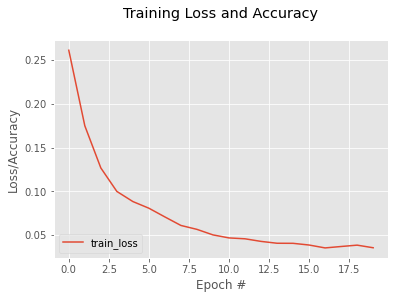

In [23]:
plot_model_loss(H2, "loss_plot_model_2.png")


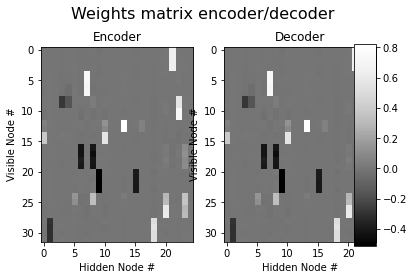

In [14]:
plot_weights_mode(model2, "weights_plot_model_2.png")

In [15]:
def generate_evolution_plot(encoder, decoder, array, path = "solution_development_model_2.png", learning_steps = 50):
    N = np.shape(array)[-1] # size of the array 
    index = np.random.randint(N) #choose random index to flip 
    candidate_solution = array[index]# pick up random sample 
    sol_evol = [] # list to store steps of evolution 
    sol_evol.append(candidate_solution)
    current_fittnes = ut.hiff_fitness(candidate_solution)
    print(candidate_solution)
    for i in range(learning_steps-1):
        new_candidate_sol = copy.copy(candidate_solution)
        output_tensor, output_array, new_fitness = code_flip_decode(new_candidate_sol, encoder, decoder)
        if new_fitness >= current_fittnes:
            candidate_solution = output_array 
            current_fittnes = new_fitness
        sol_evol.append(candidate_solution)

    tmp = np.array(sol_evol)
    plt.figure()
    plt.imshow(tmp, interpolation='nearest', cmap=cm.Greys_r)
    plt.title("Solution Development at Evolution Step 1")
    plt.xlabel("Solution variable")
    plt.ylabel("Development Step")
    plt.colorbar()
   # plt.savefig(path)
    plt.show()


[1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1.]


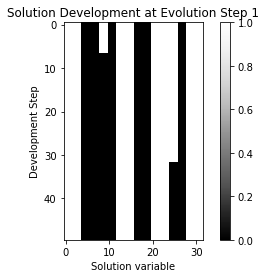

In [14]:
generate_evolution_plot(encoder, decoder, trainY)

In [16]:

def generate_trajectory_plot(encoder, decoder, array, target_size = 10, learning_steps = 30,):    
    normalization_factor = ut.hiff_fitness(np.ones((np.shape(array)[-1],)))
    trajectory_samples = []
    modified_data_set = np.ndarray(shape=(target_size,np.shape(array)[-1]))
    for k in range(target_size):
        current_array = array[k]
        current_fitness = ut.hiff_fitness(current_array)
        current_target_trajectory = []
        current_target_trajectory.append(current_fitness/normalization_factor)
        for i in range(learning_steps-1):
            output_tensor, output_array, new_fitness = code_flip_decode(current_array, encoder, decoder)
            if new_fitness >= current_fitness:
                current_fitness = new_fitness
                current_array = output_array
                current_target_trajectory.append(new_fitness/normalization_factor)
            else:
                current_target_trajectory.append(current_target_trajectory[-1])
            
        modified_data_set[k] = current_array
        trajectory_samples.append(current_target_trajectory)
    return modified_data_set, np.asarray(trajectory_samples)
    

In [17]:
def generate_trajectory_global_plot(encoder, decoder, array, epochs = 20, 
                                    learning_steps = 50, target_size = 10 ,
                                    path = "trajectory_model_2.png", debuge_variation = False, threshold = 5):

    loop_done = False
    fitness_history = [] 
    iteration = 0 
    while iteration <= epochs and not loop_done:
        array, trajectory_samples = generate_trajectory_plot(
                                        encoder=encoder, decoder = decoder,
                                        array = array,
                                        learning_steps = learning_steps, 
                                        target_size = target_size)
        fitness_history.append(trajectory_samples[:,-1])
        
        if debuge_variation:
            print(trajectory_samples[:,-1], " at iteration: ", iteration)

        if iteration > threshold and (fitness_history[-threshold] ==fitness_history[-1]).all():
           loop_done = True
           print("[INFO]: Loop was terminated after: ", iteration, " iterations, due to the lack of improvement!!!")

        iteration += 1
        

    plt.figure()
    plt.title("History Solution Trajectory after "+ str(epochs)+ " Epochs | epoch = " + str(learning_steps))
    fitness_history = np.asarray(fitness_history)
    X = np.arange(iteration)
    for i in range(iteration+1):
        plt.plot(X, fitness_history[:,i])
    plt.xlabel("epoch")
    plt.ylabel("fitness \ max_fitness")
    plt.show()
    return trajectory_samples
    


[0.65  0.7   0.7   0.625 0.9   0.575 0.7   0.625 0.65  0.725]  at iteration:  0
[0.65  0.7   0.7   0.625 0.9   0.6   0.7   0.625 0.65  0.725]  at iteration:  1
[0.65  0.7   0.7   0.625 0.9   0.6   0.7   0.625 0.65  0.725]  at iteration:  2
[0.65  0.7   0.7   0.625 0.9   0.6   0.7   0.625 0.65  0.725]  at iteration:  3
[0.65  0.7   0.7   0.625 0.9   0.6   0.7   0.625 0.65  0.725]  at iteration:  4
[0.65  0.7   0.7   0.625 0.9   0.6   0.7   0.625 0.65  0.725]  at iteration:  5
[0.65  0.7   0.7   0.625 0.9   0.6   0.7   0.625 0.65  0.725]  at iteration:  6
[INFO]: Loop was terminated after:  6  iterations, due to the lack of improvement!!!


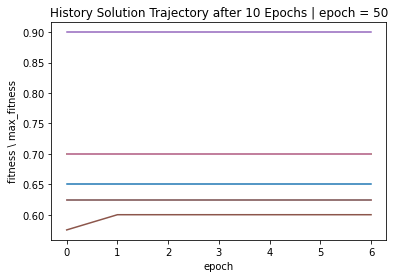

In [17]:
tmp = generate_trajectory_global_plot(encoder, decoder, trainY, debuge_variation=True, epochs = 10)

In [18]:
def add_layer_to_model(model, compression = 0.8, dropout = 0.2, reg_cof = 0.001, show_summary = False):
    """
    To do: 
     - add activation parameter
     - add stddev param
     - add initializer param 
    Add new layer to the middle of the model.

    Parameters:
        model - model to which we would like to add new layer 

    Optional parameters:
        compression (default 0.8) - level of compression compared to the latent space of the model 
        droupout (default 0.2) - dropout of the drop layer before new latent layer 
        reg_cof (default 0.001) - reguralization coefficient for new latent space 
        show_summary (default False) - variable to show new model structure
    """
    encoder_old, decoder_old = split_model_into_encoder_decoder(model) #split the old model into encoder and decoder
    latent_size = encoder_old.layers[-1].output.shape[-1] # calculate new latent size 
    input_shape =  model.input_shape[-1] # extract input shape 
    inputs = Input(shape=(input_shape,)) # explicitly define input layer 

    new_latent_layer = Dense( # new latent layer 
        int(latent_size * compression),activation="tanh",
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.Zeros(),kernel_regularizer=tf.keras.regularizers.l1(reg_cof))
    new_decoding_layer = DenseTranspose(dense = new_latent_layer) # create dependant "diverging" layer

    x = encoder_old.layers[1](inputs) # add first layers: input -> encoder.layers[1]
    for e in encoder_old.layers[2:]: # add model encoder
        x = e(x)

    x = new_latent_layer(x) # add latent laver 
    x = new_decoding_layer(x) # add transition "diverging" layer
    for d in decoder_old.layers[1:]: # add model decoder
        x = d(x)

    new_model = tf.keras.Model(inputs, x) # construct model 
    opt = Adam(lr=0.01) # set up optimizer
    new_model.compile(loss='mse', optimizer=opt) # compile model 
    if show_summary:
        new_model.summary()
    return new_model

In [19]:
model3 = add_layer_to_model(model2, show_summary=True)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  825       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_transpose_2 (DenseTran (None, 25)                545       
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 32)                857       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________

In [20]:
H3 = model3.fit(
    trainY2, trainY2, 
    epochs = epochs, 
    batch_size = batch_size,
    verbose = 1,
    shuffle = True
)

Epoch 1/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2640
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2144
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.1611
Epoch 4/20
20/20 [==============================] - 0s 2ms/step - loss: 0.1371
Epoch 5/20
20/20 [==============================] - 0s 2ms/step - loss: 0.1081
Epoch 6/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0835
Epoch 7/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0781
Epoch 8/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0716
Epoch 9/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0738
Epoch 10/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0743
Epoch 11/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0712
Epoch 12/20
20/20 [==============================] - 0s 2ms/step - loss: 0.0679
Epoch 13/20
20/20 [==============================

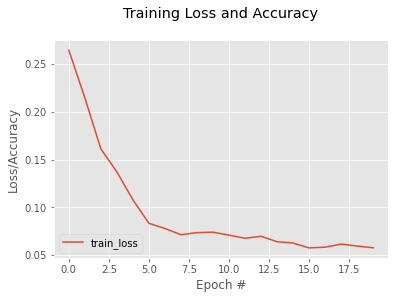

In [22]:
plot_model_loss(H3, "to_delete.png")

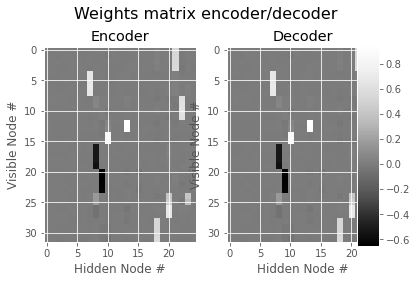

In [23]:
plot_weights_mode(model3, "to_delete_2.png")

[INFO]: number of convoluted layers is equal to:  2


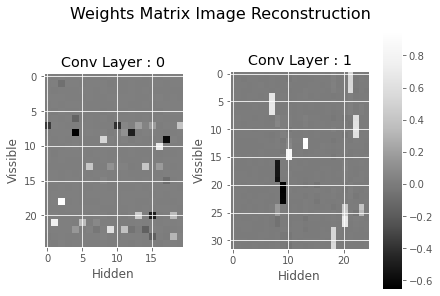

In [167]:
plot_weights_model(model3)

In [159]:
encoder3, decoder3 = split_model_into_encoder_decoder(model3, True)

---------------------------- ENCODER ----------------------------
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  825       
_________________________________________________________________
dense_2 (Dense)              multiple                  520       
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________

---------------------------- DECODER ------------------------
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape  

In [160]:
trainY3 = generate_new_training_set(trainY2, encoder3, decoder3)

[0.9   0.85  0.85  0.75  1.    0.85  0.85  1.    0.825 1.   ]  at iteration:  0
[0.9  0.85 0.85 0.75 1.   0.85 0.85 1.   0.9  1.  ]  at iteration:  1
[0.9  0.85 0.85 0.75 1.   0.85 0.85 1.   0.9  1.  ]  at iteration:  2
[0.9  0.85 0.85 0.75 1.   0.85 0.85 1.   0.9  1.  ]  at iteration:  3
[0.9  0.85 0.85 0.75 1.   0.85 0.85 1.   0.9  1.  ]  at iteration:  4
[0.9  0.85 0.85 0.75 1.   0.85 0.85 1.   0.9  1.  ]  at iteration:  5
[0.9  0.85 0.85 0.75 1.   0.85 0.85 1.   0.9  1.  ]  at iteration:  6
[INFO]: Loop was terminated after:  6  iterations, due to the lack of improvement!!!


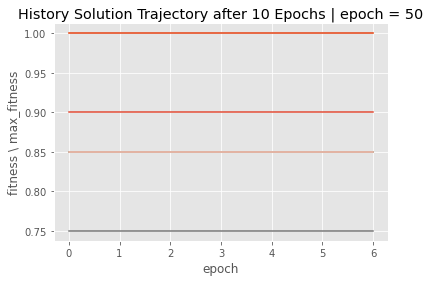

In [162]:
tmp = generate_trajectory_global_plot(encoder3, decoder3, trainY, debuge_variation=True, epochs = 10)
# as we expected working "DEEPER" brings better results 